In [1]:
import os
import re
import glob
import json
import bisect
import feather

import numpy as np
import pandas as pd
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
from statistics import mean
from itertools import product, chain
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pandas.plotting import scatter_matrix

# Bokeh
from bokeh.palettes import Viridis256
from bokeh.io import output_notebook, output_file
from bokeh.resources import INLINE
from bokeh.models import WMTSTileSource
from bokeh.plotting import show, figure, ColumnDataSource
from bokeh.models import ColorBar, LinearColorMapper, HoverTool, ColumnDataSource
output_notebook(INLINE)


def escalar_features(df, cols, rango):
    for col in cols:
        scaler = MinMaxScaler(rango)
        scaled_value = scaler.fit_transform(df_features[col].values.reshape(-1, 1))
        df.loc[:, col] = pd.Series(data=scaled_value.flatten(), index=df.index)
    return df


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config IPCompleter.use_jedi = False

Loading BokehJS ...

### Cargar features

In [2]:
columnas_features = {
    'general': [
        'monto_total',
        'proveedores_distintos',
        'conteo_procedimientos',
        'conteo_contratos',
    ],
    'competencia': [
        'contratos_por_proveedor',
        'pc_procedimientos_adjudicacion_directa',
        'pc_monto_adjudicacion_directa',
        'pc_procedimientos_invitacion_a_cuando_menos_tres',
        'pc_monto_invitacion_a_cuando_menos_tres',
        'IHH_total_contratos',
        'IHH_total_monto',
        'ID_total_contratos',
        'ID_total_monto',
        'tendencia_adj_directa',
        # participantes
        'pc_licitaciones_un_participante',
        'procs_promedio_por_participantes',
        'pc_partipaciones_promedio',
        'procs_por_participantes',
        'disminucion_participacion',
    ],
    'transparencia': [
        # procedimientos
        'pc_procedimientos_presenciales',
        'contratos_promedio_por_proc',
        'promedio_datos_faltantes',
        # scraper
        'pc_sin_contrato',
        'pc_sin_fallo',
        'pc_sin_apertura',
        'pc_procs_sin_archivos',
        'promedio_procs_por_archivo',
        'tendencia_no_publicacion_contratos',
        'pc_adjudicaciones_incompletas',
        'pc_invitaciones_incompletas',
        'pc_licitaciones_incompletas',
        
    ],
    'anomalias': [
        # Procedimientos
        # 'num_proveedores_fantasma',
        # 'contratos_con_fantasmas',
        'monto_fantasma',
        # 'num_proveedores_sancionados',
        # 'contratos_con_sancionados',
        'monto_con_sancionados',
        'pc_contratos_convenio_si',
        'pc_licitaciones_menor_15',
        'pc_licitaciones_menor_20',
        'pc_licitaciones_menor_40',
        'pc_estratificacion_mal_reportada',
        'pc_adj_excedidas_prom',
        'pc_inv3_excedidas_prom',
        # Scraper
        'promedio_convenios',
        'pc_sin_junta',
        'pc_sin_convocatoria',

    ]
}

tipos_contratacion = (
    'ADQUISICIONES',
    'SERVICIOS',
    'OBRA PUBLICA',
    'ARRENDAMIENTOS',
    'SERVICIOS RELACIONADOS CON LA OP'
)

thresholds = {
    'ADQUISICIONES': 10,
    'SERVICIOS': 15,
    'OBRA PUBLICA': 4,
    'ARRENDAMIENTOS': 3,
    'SERVICIOS RELACIONADOS CON LA OP': 3
}

conceptos = list(columnas_features.keys())

features = {}
# competencia tiene los datos generales
# por tipo cargas todos los conceptos y seleccionas las columnas para cada concepto
for tipo  in tipos_contratacion:
    df_conceptos = []
    for concepto in conceptos:
        file_path = os.path.join('../data/conceptos/', concepto, tipo, 'features.csv')
        df_features = pd.read_csv(file_path, dtype={'CLAVEUC': str})
        df_features = df_features.set_index('CLAVEUC')
        df_conceptos.append(df_features)
    df_conceptos = pd.concat(df_conceptos, axis=1, join='inner')
    # Remover unidades con pocas observaciones (remover por tipo)
    df_conceptos = df_conceptos.loc[df_conceptos.conteo_contratos > thresholds[tipo]]
    
    for concepto in conceptos:
        # Seleccionar columnas de interes (remover por concepto)

        prueba = [c for c in columnas_features[concepto] if c not in df_conceptos.columns]
        if len(prueba) > 0:
            print(concepto, tipo)
            print(prueba)
        df_features = df_conceptos.loc[:, columnas_features[concepto]]
        # print(f'{tipo} - {concepto}')
        # print(df_features.shape[0] - df_features.dropna().shape[0])
        df_features = df_features.fillna(0)
        if concepto != 'general':
            df_features = escalar_features(df_features, df_features.columns, (0, 100))
        features[(tipo, concepto)] = df_features


### Genera los escalamientos de 0-100 y promedia los features de cada concepto

In [3]:
scores = {}
for tipo, concepto in product(tipos_contratacion, conceptos):
    if concepto == 'general':
        continue
    df_aux = features[tipo, concepto].mean(axis=1)
    # Escalar de 0 a 100
    scaler = MinMaxScaler((0, 100))
    df_aux = pd.Series(
        scaler.fit_transform(df_aux.values.reshape(-1, 1)).flatten(),
        index=df_aux.index
    )
    # guardar
    scores[tipo, concepto] = df_aux

## Cargar nombres

In [4]:
df_procedimientos = feather.read_dataframe(
    '../data/bases/procedimientos_all_2017_10_29.feather',
    columns=['CLAVEUC', 'DEPENDENCIA', 'NOMBRE_DE_LA_UC', 'SIGLAS'], nthreads=7,
)
# dependencias
df_nombres_dep = df_procedimientos.loc[:, ['CLAVEUC', 'SIGLAS']].drop_duplicates()
nombres_dep = {row.CLAVEUC: row.SIGLAS for row in df_nombres_dep.itertuples()}

#unidades
df_nombres_uc = df_procedimientos.loc[:, ['CLAVEUC', 'NOMBRE_DE_LA_UC']].drop_duplicates()
nombres_uc = {row.CLAVEUC: row.NOMBRE_DE_LA_UC for row in df_nombres_uc.itertuples()}
del df_procedimientos, df_nombres_dep, df_nombres_uc

### Agrega los nombres de las dependencias y UCs


In [5]:

scores_tipo = {}
for tipo in tipos_contratacion:
    df_aux = pd.concat(
        [scores[tipo, concepto] for concepto in conceptos if concepto != 'general'],
        axis=1, join='outer'
    )
    df_aux = df_aux.rename(
        columns={(i - 1): conceptos[i] for i in range(1, 4)}
    )
    # Asignar dependencia y uc
    df_aux = df_aux.reset_index()
    df_aux = df_aux.assign(dependencia=df_aux.CLAVEUC.map(nombres_dep))
    df_aux = df_aux.assign(nombre_uc=df_aux.CLAVEUC.map(nombres_uc))
    df_aux = df_aux.set_index('CLAVEUC')
    # Pegar (Join) de datos generales
    df_aux = df_aux.join(features[tipo, 'general'], how='inner')    
    # guardar
    scores_tipo[tipo] = df_aux


### Calculo Riesgo para cada UC

In [6]:
def calcular_riesgo(scores):
    tipos_contratacion = (
        'SERVICIOS',
        'ARRENDAMIENTOS',
        'ADQUISICIONES',
        'OBRA PUBLICA',
        'SERVICIOS RELACIONADOS CON LA OP'
    )    
    df_montos = []
    for tipo in tipos_contratacion:
        df_test = scores[tipo].copy()
        df_test = df_test[['monto_total']]
        df_test = df_test.rename(columns={'monto_total': f'monto_total_{tipo}'})
        df_montos.append(df_test)
    df_montos = pd.concat(df_montos, axis=1)
    print(df_montos.shape)
    df_montos = df_montos.sum(axis=1)
    df_montos.name = 'MONTO'
    df_montos = df_montos.to_frame()
    # 
    ponderados = {}
    cols_interes = ['competencia', 'transparencia', 'anomalias', 'monto_total']
    conceptos = ('competencia', 'transparencia', 'anomalias')
    for tipo in tipos_contratacion:
        df_test = scores[tipo].copy()
        df_test = df_test.loc[:, cols_interes]
        df_test = df_test.join(df_montos, how='inner')
        pc_monto = df_test.monto_total.divide(df_test.MONTO)
        df_test = df_test.drop(['monto_total', 'MONTO'], axis=1)
        for concepto in conceptos:
            df_test.loc[:, concepto] = df_test.loc[:, concepto] * pc_monto
        ponderados[tipo] = df_test
        
    df_concepto_ponderado = []
    for concepto in conceptos:
        df_valor = pd.concat(
            [ponderados[tipo][concepto] for tipo in tipos_contratacion],
            axis=1).sum(axis=1)
        df_valor.name = concepto
        df_valor = df_valor.to_frame()
        df_concepto_ponderado.append(df_valor)
    #
    df_concepto_ponderado = pd.concat(df_concepto_ponderado, axis=1)
    riesgo = df_concepto_ponderado.mean(axis=1)
    return riesgo


riesgo_uc = calcular_riesgo(scores_tipo)
riesgo_uc.name = 'Riesgo'
riesgo_uc = riesgo_uc.to_frame()
print(riesgo_uc.shape)
riesgo_uc.head()

(1574, 5)
(1574, 1)


,Riesgo
002000997,68.436536
002000998,19.298097
002000999,34.515115
003000997,49.067370
004000995,31.908306


In [7]:
scores_tipo_riesgo = {}
for tipo in tipos_contratacion:
    df_aux = scores_tipo[tipo]
    # Asignar riesgo
    df_aux = df_aux.join(riesgo_uc, how='inner')
    # guardar
    scores_tipo_riesgo[tipo] = df_aux

In [24]:
# scores_tipo_riesgo['SERVICIOS']

## Generar score_tipo para las dependencias

In [8]:
def generar_scores_dep(scores):
    tipos_contratacion = (
        'SERVICIOS',
        'ARRENDAMIENTOS',
        'ADQUISICIONES',
        'OBRA PUBLICA',
        'SERVICIOS RELACIONADOS CON LA OP'
    )
    cols_interes = [
        'CLAVEUC', 'dependencia', 'competencia',
        'transparencia', 'anomalias', 'monto_total',
        'conteo_procedimientos'
    ]
    scores_out = {}
    for tipo in tipos_contratacion:
        df_aux = scores[tipo].copy()
        df_aux = df_aux.reset_index()
        df_aux = df_aux.loc[:, cols_interes]
        monto_depend_tipo = (df_aux.groupby('dependencia',
                                            as_index=False)
                                   .conteo_procedimientos.sum())
        df_aux = df_aux.assign(
            competencia=df_aux.competencia * df_aux.monto_total,
            transparencia=df_aux.transparencia * df_aux.monto_total,
            anomalias=df_aux.anomalias * df_aux.monto_total,
        )
        df_dep = df_aux.groupby('dependencia', as_index=False).sum()
        df_dep = df_dep.assign(
            competencia=df_dep.competencia.divide(df_dep.monto_total),
            transparencia=df_dep.transparencia.divide(df_dep.monto_total),
            anomalias=df_dep.anomalias.divide(df_dep.monto_total),
        )
        # df_dep = df_dep.drop('monto_total', axis=1)
        scores_out[tipo] = df_dep.set_index('dependencia')
    return scores_out

scores_dep = generar_scores_dep(scores_tipo)
scores_dep['SERVICIOS'].head()

,competencia,transparencia,anomalias,monto_total,conteo_procedimientos
dependencia,,,,,
AEM,44.456092,71.840799,61.254102,2.193410e+07,35
AFSEDF,62.066271,61.974835,34.885300,1.485592e+09,462
AGN,41.942673,53.562070,29.788164,6.734279e+07,129
AGROASEMEX,28.929089,45.187349,53.792015,3.148478e+08,412
AICM,34.319183,16.851447,66.300940,6.606779e+09,568


In [9]:
riesgo_dep = calcular_riesgo(scores_dep)
riesgo_dep.name = 'Riesgo'
riesgo_dep = riesgo_dep.to_frame()
riesgo_dep.head()

(265, 5)


,Riesgo
AEM,59.212821
AFSEDF,50.399727
AGN,35.074008
AGROASEMEX,41.717584
AICM,39.565226


In [10]:
scores_dep_riesgo = {}
for tipo in tipos_contratacion:
    df_aux = scores_dep[tipo]
    # Asignar riesgo
    df_aux = df_aux.join(riesgo_dep, how='inner')
    # guardar
    scores_dep_riesgo[tipo] = df_aux

In [11]:
df_aux.head()

,competencia,transparencia,anomalias,monto_total,conteo_procedimientos,Riesgo
AGN,28.077096,43.080553,49.855063,6.074527e+07,21,35.074008
AGROASEMEX,49.639050,50.722585,42.927675,1.991706e+06,8,41.717584
AICM,29.598412,44.173777,29.824576,1.955789e+08,133,39.565226
API-ALTAMIRA,34.377505,31.569723,49.395723,1.465283e+08,130,43.732583
API-COATZACOALCOS,31.940578,64.682191,47.545554,6.551250e+07,46,39.254440


## Generar fichas (UCs)

In [47]:

def extraer_informacion(identidicador, df, palette):
    try:
        serie = df.loc[identidicador]
        valores = [
            f'{serie.competencia:.0f}',
            f'{serie.transparencia:.0f}',
            f'{serie.anomalias:.0f}',
            # '50',
            f'${serie.monto_total:,.02f}',
            f'{serie.conteo_procedimientos:,}',
        ]
        riesgo = f'{serie.Riesgo:.0f}',
        colores = [
            palette[int(serie.competencia)],
            palette[int(serie.transparencia)],
            palette[int(serie.anomalias)],
            # '#FFFFFF',
            '#FFFFFF',
            '#FFFFFF'
        ]
        riesgo_color = palette[int(serie.Riesgo)]
    except KeyError:
        valores = [''] * 5
        colores = ['#BDBDBD'] * 5
    return valores, colores


def generar_archivos(scores, unidades_compradoras, tipos, palette, path, dependencia_card=False):
    for i, uc in enumerate(unidades_compradoras):
        if dependencia_card:
            template = {
                'dependencia': uc,
                'riesgo': 'XX.',
                'datos': {
                    'columnas': [
                        'Falta de competencia',
                        'Falta de transparencia', 
                        'Anomalías',
                        # 'Percentil',
                        'Monto',
                        'Total de procedimientos',
                    ],
                    'valores': list(),
                    'colores': list(),
                }

            }
        else:
            template = {
                'uc': nombres_uc[uc],
                'dependencia': nombres_dep[uc],
                'riesgo': 'XX.',
                'datos': {
                    'columnas': [
                        'Falta de competencia',
                        'Falta de transparencia', 
                        'Anomalías',
                        # 'Percentil',
                        'Monto',
                        'Total de procedimientos',
                    ],
                    'valores': list(),
                    'colores': list(),
                }

            }
        valores = []
        colores = []
        riesgo = None
        riesgo_color = None
        for tipo in tipos_contratacion:
            df_aux = scores[tipo]
            df_aux = df_aux.copy()
            if riesgo is None:
                try:
                    df_riesgo = df_aux.loc[uc]
                    riesgo = str(int(df_riesgo.Riesgo))
                    # riesgo = f'{int(df_riesgo.Riesgo)}',
                    riesgo_color = palette[int(df_riesgo.Riesgo)]
                    # print(riesgo)
                except KeyError:
                    pass
            vals, cols = extraer_informacion(uc, df_aux, palette)        
            valores.append(vals)
            colores.append(cols)
        template['datos']['valores'] = valores
        template['datos']['colores'] = colores
        template['riesgo'] = {'valor': riesgo, 'color': riesgo_color}
        # guardar templates
        with open(f'{path}/{uc}.json', 'w', encoding='utf-8') as f:
            json.dump(template, f, ensure_ascii=False)
            
    
# Generar todas las UCs
unidades_compradoras = set(
    chain.from_iterable(
        [list(df.index.unique()) for df in scores_tipo.values()]
    )
)

tipos_contratacion = (
    'SERVICIOS',
    'ARRENDAMIENTOS',
    'ADQUISICIONES',
    'OBRA PUBLICA',
    'SERVICIOS RELACIONADOS CON LA OP'
)

palette_colores = [matplotlib.colors.to_hex(c)
                   for c in sns.color_palette("Spectral", 101)]

palette_colores.reverse()

path = 'src/city/city/feed'
generar_archivos(scores_tipo_riesgo, unidades_compradoras, tipos_contratacion, palette_colores, path)


## Generar fichas (Dependencias)

In [44]:


dependencias = set(
    chain.from_iterable(
        [list(df.index.unique()) for df in scores_dep_riesgo.values()]
    )
)

tipos_contratacion = (
    'SERVICIOS',
    'ARRENDAMIENTOS',
    'ADQUISICIONES',
    'OBRA PUBLICA',
    'SERVICIOS RELACIONADOS CON LA OP'
)

palette_colores = [matplotlib.colors.to_hex(c)
                   for c in sns.color_palette("Spectral", 101)]

palette_colores.reverse()
path = 'src/city/city/feed_dep'

generar_archivos(scores_dep_riesgo, dependencias, tipos_contratacion, palette_colores, path, True)

In [20]:
# generar_archivos(scores, unidades_compradoras, tipos)

In [12]:
# scores_tipo_riesgo['SERVICIOS']

## 10 top y bottom (UCs)

In [18]:
list(features.keys())

[('ADQUISICIONES', 'general'),
 ('ADQUISICIONES', 'competencia'),
 ('ADQUISICIONES', 'transparencia'),
 ('ADQUISICIONES', 'anomalias'),
 ('SERVICIOS', 'general'),
 ('SERVICIOS', 'competencia'),
 ('SERVICIOS', 'transparencia'),
 ('SERVICIOS', 'anomalias'),
 ('OBRA PUBLICA', 'general'),
 ('OBRA PUBLICA', 'competencia'),
 ('OBRA PUBLICA', 'transparencia'),
 ('OBRA PUBLICA', 'anomalias'),
 ('ARRENDAMIENTOS', 'general'),
 ('ARRENDAMIENTOS', 'competencia'),
 ('ARRENDAMIENTOS', 'transparencia'),
 ('ARRENDAMIENTOS', 'anomalias'),
 ('SERVICIOS RELACIONADOS CON LA OP', 'general'),
 ('SERVICIOS RELACIONADOS CON LA OP', 'competencia'),
 ('SERVICIOS RELACIONADOS CON LA OP', 'transparencia'),
 ('SERVICIOS RELACIONADOS CON LA OP', 'anomalias')]

In [20]:
nombres_uc['007HXA999']

'ISSFAM-DIRECCION DE OBRAS #007HXA999'

In [74]:
df_all_montos = []
for tipo in tipos_contratacion:
    df_aux = features[tipo, 'general']
    df_aux = df_aux.loc[:, ['monto_total']]
    df_aux = df_aux.rename(columns={'monto_total': f'monto_total_{tipo}'})
    df_all_montos.append(df_aux)
df_all_montos = pd.concat(df_all_montos, axis=1)
df_all_montos = df_all_montos.assign(monto=df_all_montos.sum(axis=1))
df_all_montos.head()

,monto_total_ADQUISICIONES,monto_total_SERVICIOS,monto_total_OBRA PUBLICA,monto_total_ARRENDAMIENTOS,monto_total_SERVICIOS RELACIONADOS CON LA OP,monto
002000997,3.896830e+07,NaN,NaN,NaN,NaN,3.896830e+07
002000998,4.248019e+07,NaN,NaN,NaN,NaN,4.248019e+07
002000999,2.133699e+08,2.287082e+09,NaN,55527512.29,NaN,2.555980e+09
003000997,3.864073e+07,NaN,NaN,NaN,NaN,3.864073e+07
004000995,1.685789e+07,1.218403e+09,NaN,NaN,NaN,1.235261e+09


In [79]:
df_nueva =riesgo_uc.join(df_all_montos)[['Riesgo', 'monto']].sort_values('Riesgo', ascending=False)

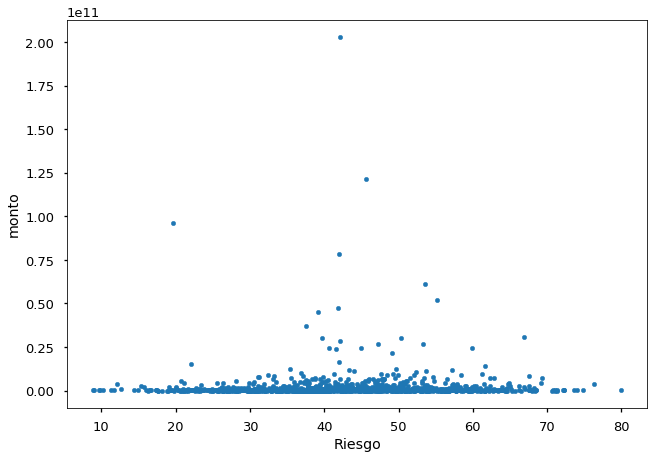

In [100]:
with plt.style.context('seaborn-talk'):
    df_nueva.assign(
        log_monto= lambda data: np.log(data.monto)
    ).plot.scatter(x='Riesgo', y='monto')

In [82]:
scores_dep_riesgo.keys()

dict_keys(['ADQUISICIONES', 'SERVICIOS', 'OBRA PUBLICA', 'ARRENDAMIENTOS', 'SERVICIOS RELACIONADOS CON LA OP'])

In [94]:
df_dep_montos = []
for tipo in tipos_contratacion:
    df_aux = scores_dep_riesgo['ADQUISICIONES'].loc[:, ['monto_total', 'Riesgo']]
    df_aux = df_aux.rename(columns={'monto_total': f'monto_total_{tipo}', 'Riesgo': f'Riesgo_{tipo}'})
    df_dep_montos.append(df_aux)
df_dep_montos = pd.concat(df_dep_montos, axis=1)
columnas = [c for c in df_dep_montos.columns if 'monto_total' in c]
df_dep_montos = df_dep_montos.assign(
    monto=df_dep_montos[columnas].sum(axis=1)
)
df_dep_montos = df_dep_montos.loc[:, ['Riesgo_SERVICIOS', 'monto']]
df_dep_montos = df_dep_montos.sort_values('Riesgo_SERVICIOS', ascending=False)
df_dep_montos.head(100)

,Riesgo_SERVICIOS,monto
ISSFAM,71.335492,1.241353e+09
RAN,68.816913,1.834581e+08
PDC,68.182778,1.496456e+08
CIQA,67.516201,4.499329e+08
CMM,65.048919,8.058854e+09
INCAN,64.726268,2.720433e+10
CONAMPROS,64.326210,4.477559e+07
SIAP,63.076963,2.581711e+08
PA,62.726160,9.156563e+08
PRS,62.326468,1.132859e+10


In [103]:
# df_dep_montos.sort_values(['Riesgo_SERVICIOS', 'monto'], ascending=False)

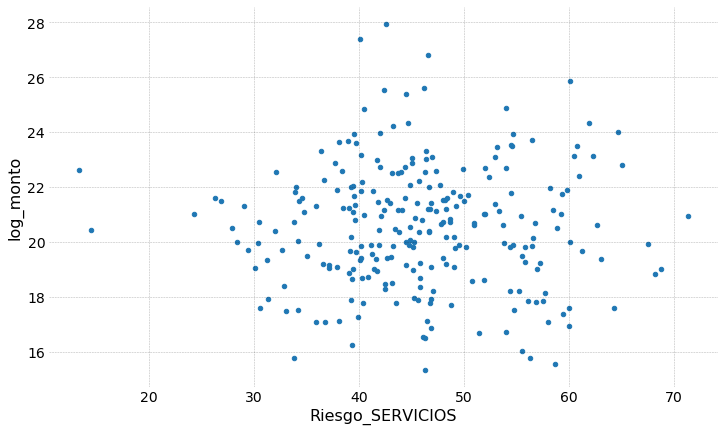

In [101]:
with plt.style.context('randy_olson_style'):
    df_dep_montos.assign(
        log_monto=lambda data: np.log(data.monto)
    ).plot.scatter(x='Riesgo_SERVICIOS', y='log_monto')

In [115]:
df_algo = df_dep_montos.loc[df_dep_montos.monto > 1e9].head(10)
df_algo

,Riesgo_SERVICIOS,monto
ISSFAM,71.335492,1.241353e+09
CMM,65.048919,8.058854e+09
INCAN,64.726268,2.720433e+10
PRS,62.326468,1.132859e+10
SEMAR,61.907934,3.765388e+10
HRAEI,60.948336,5.362043e+09
CINVESTAV,60.765755,1.594245e+10
ESSA,60.532271,1.128469e+10
DICONSA,60.149554,1.736568e+11
SPR,59.824174,3.263835e+09


In [116]:
df_algo.monto.map(lambda x: f'$ {x:,.02f}')

ISSFAM         $ 1,241,353,429.31
CMM            $ 8,058,853,791.28
INCAN         $ 27,204,331,066.50
PRS           $ 11,328,590,767.88
SEMAR         $ 37,653,881,987.69
HRAEI          $ 5,362,042,527.96
CINVESTAV     $ 15,942,447,128.38
ESSA          $ 11,284,689,372.69
DICONSA      $ 173,656,848,300.54
SPR            $ 3,263,835,299.61
Name: monto, dtype: object

In [78]:
df_all_montos.monto.describe()

count    1.574000e+03
mean     1.484036e+09
std      7.723687e+09
min      1.689655e+05
25%      3.390198e+07
50%      1.518857e+08
75%      7.327322e+08
max      2.028069e+11
Name: monto, dtype: float64

In [13]:
# df_juntar = df_all_montos.reset_index()
# df_juntar = df_juntar.rename(columns={'index': 'CLAVEUC'})
# df_juntar = df_juntar.loc[: ,['CLAVEUC', 'monto']]
# # df_juntar

In [132]:
df_algo = riesgo_uc.sort_values('Riesgo', ascending=False).head(20).reset_index()
df_algo = df_algo.rename(columns={'index': 'CLAVEUC'})
df_algo = df_algo.assign(
    dependencia=df_algo.CLAVEUC.map(lambda x: nombres_dep[x]),
    nombre=df_algo.CLAVEUC.map(lambda x: nombres_uc[x]),
)
df_algo = pd.merge(df_algo, df_juntar, on='CLAVEUC')
df_algo
# df_algo.to_csv('/home/raul/Downloads/riesgo_uc.csv', index=False,encoding='utf-8', quoting=1)

,CLAVEUC,Riesgo,dependencia,nombre,monto
0,019GYR059,79.911233,IMSS,IMSS-UMAE HOSPITAL DE ESPECIALIDADES N25 DEPTO...,1.185069e+08
1,007HXA999,76.238123,ISSFAM,ISSFAM-DIRECCION DE OBRAS #007HXA999,3.509912e+09
2,019GYN882,74.797384,ISSSTE,ISSSTE-HOSPITAL REGIONAL MORELIA COORDINACION ...,2.119684e+08
3,019GYR091,73.994305,IMSS,IMSS-UMAE HOSPITAL DE TRAUMATOLOGIA Y ORTOPEDI...,2.467249e+08
4,019GYR071,73.642444,IMSS,IMSS-HOSPITAL DE TRAUMATOLOGIA Y ORTOPEDIA LOM...,5.287740e+08
5,015B00001,72.292378,RAN,RAN-DIRECCION GENERAL DE FINANZAS Y ADMINISTRA...,2.607409e+08
6,018TOQ833,72.217409,CFE,CFE-COMISION FEDERAL DE ELECTRICIDAD DCO ZONA ...,5.471093e+08
7,019GYN895,72.133925,ISSSTE,ISSSTE-HOSPITAL REGIONAL TIPO,3.186427e+08
8,047AYB020,71.352969,CDI,CDI-DELEGACION ESTATAL PUEBLA #047AYB020,4.401260e+08
9,009JZL043,71.334338,ASA,ASA-ESTACION DE COMBUTIBLES DE ZACATECAS,2.688118e+06


In [133]:
uc_eval = '015B00001'
tipo = 'SERVICIOS'
nombres_uc[uc_eval]

'RAN-DIRECCION GENERAL DE FINANZAS Y ADMINISTRACION'

In [134]:
df_all_montos.loc[uc_eval]

monto_total_ADQUISICIONES                       3.389814e+07
monto_total_SERVICIOS                           2.253272e+08
monto_total_OBRA PUBLICA                                 NaN
monto_total_ARRENDAMIENTOS                      1.515527e+06
monto_total_SERVICIOS RELACIONADOS CON LA OP             NaN
monto                                           2.607409e+08
Name: 015B00001, dtype: float64

In [59]:
df_test = features[tipo, 'competencia']
df_test.loc[uc_eval]

contratos_por_proveedor                              2.044487
pc_procedimientos_adjudicacion_directa              82.692308
pc_monto_adjudicacion_directa                       78.417164
pc_procedimientos_invitacion_a_cuando_menos_tres    15.865385
pc_monto_invitacion_a_cuando_menos_tres             15.016971
IHH_total_contratos                                  3.573362
IHH_total_monto                                      5.142312
ID_total_contratos                                   7.792075
ID_total_monto                                      16.672419
tendencia_adj_directa                               55.545484
pc_licitaciones_un_participante                     80.000000
procs_promedio_por_participantes                    83.333333
pc_partipaciones_promedio                           33.333333
procs_por_participantes                             25.000000
disminucion_participacion                           41.444142
Name: 015B00001, dtype: float64

In [60]:
df_test = features[tipo, 'transparencia']
df_test.loc[uc_eval]

pc_procedimientos_presenciales         79.807692
contratos_promedio_por_proc             0.217590
promedio_datos_faltantes               62.605617
pc_sin_contrato                       100.000000
pc_sin_fallo                          100.000000
pc_sin_apertura                        94.117647
pc_procs_sin_archivos                  89.325843
promedio_procs_por_archivo             74.789916
tendencia_no_publicacion_contratos     50.000000
pc_adjudicaciones_incompletas         100.000000
pc_invitaciones_incompletas           100.000000
pc_licitaciones_incompletas           100.000000
Name: 015B00001, dtype: float64

In [61]:
df_test = features[tipo, 'anomalias']
df_test.loc[uc_eval]

monto_fantasma                        0.000000
monto_con_sancionados                 0.000000
pc_contratos_convenio_si             45.581395
pc_licitaciones_menor_15             91.666667
pc_licitaciones_menor_20              0.000000
pc_licitaciones_menor_40              0.000000
pc_estratificacion_mal_reportada     72.792685
pc_adj_excedidas_prom                15.300818
pc_inv3_excedidas_prom                0.000000
promedio_convenios                    0.000000
pc_sin_junta                        100.000000
pc_sin_convocatoria                 100.000000
Name: 015B00001, dtype: float64

In [51]:
df_test = features[tipo, 'general']
df_test.loc[uc_eval]

monto_total              3.502392e+09
proveedores_distintos    1.000000e+00
conteo_procedimientos    1.160000e+02
conteo_contratos         1.160000e+02
Name: 007HXA999, dtype: float64

In [17]:
riesgo_uc.sort_values('Riesgo', ascending=False)

,Riesgo
019GYR059,79.911233
007HXA999,76.238123
019GYN882,74.797384
019GYR091,73.994305
019GYR071,73.642444
015B00001,72.292378
018TOQ833,72.217409
019GYN895,72.133925
047AYB020,71.352969
009JZL043,71.334338


In [71]:
df_algo = ['ADQUISICIONES']
df_algo.loc['PDC']

competencia      5.489412e+01
transparencia    6.691478e+01
anomalias        3.490173e+01
monto_total      2.992911e+07
Name: PDC, dtype: float64

## 10 top y bottom (dependencias)

In [65]:
riesgo_dep.sort_values('Riesgo', ascending=False).head(30)

,Riesgo
ISSFAM,71.335492
RAN,68.816913
PDC,68.182778
CIQA,67.516201
CMM,65.048919
INCAN,64.726268
CONAMPROS,64.326210
CONAZA,63.609909
SIAP,63.076963
PA,62.726160


In [64]:
riesgo_dep.sort_values('Riesgo', ascending=True).head(10)

,Riesgo
INEGI,13.325570
CIDETEQ,14.445870
CONACULTA,24.311182
INPER,26.315754
CONALEP,26.883976
SACM,27.570741
CIJ,27.888263
INEE,28.340000
CIATEQ,29.034597
CIGGET,29.438145


In [20]:
# scores_dep_riesgo['SERVICIOS']

In [14]:
# riesgo_dep.plot.hist()

In [22]:
# riesgo_dep.describe()

In [23]:
# scores_dep['OBRA PUBLICA'].drop('monto_total', axis=1).max()

In [29]:
# df_concepto_ponderado = []
# for concepto in conceptos:
#     df_valor = pd.concat([ponderados[tipo][concepto] for tipo in tipos_contratacion],
#                          axis=1).sum(axis=1)
#     df_valor.name = concepto
#     df_valor = df_valor.to_frame()
#     df_concepto_ponderado.append(df_valor)
#     print(concepto)
    
# df_concepto_ponderado = pd.concat(df_concepto_ponderado, axis=1)
# df_concepto_ponderado = df_concepto_ponderado.assign(
#     Riesgo=df_concepto_ponderado.mean(axis=1)
# )
# df_concepto_ponderado.head()

In [21]:
# [nombres_uc[c] for c in df_concepto_ponderado[df_concepto_ponderado.Riesgo > 70].index]

In [47]:
# def get_pc_procs(df):
#     df = df.copy()
#     procs_por_dep = (df.groupby('dependencia', as_index=False)
#                        .conteo_procedimientos.sum()
#                        .rename(columns={'conteo_procedimientos': 'procs_dep'}))
#     df = pd.merge(df, procs_por_dep, on='dependencia', how='inner')
#     df = df.assign(
#         pc_procs_en_dep=df.conteo_procedimientos.divide(df.procs_dep)
#     )
#     df = df.loc[:, ['CLAVEUC', 'pc_procs_en_dep']]
#     return df

# def get_pc_monto(df):
#     df = df.copy()
#     monto_por_dep = (df.groupby('dependencia', as_index=False)
#                        .monto_total.sum()
#                        .rename(columns={'monto_total': 'monto_dependencia'}))
#     df = pd.merge(df, monto_por_dep, on='dependencia', how='inner')
#     df = df.assign(
#         pc_monto_en_dep=df.monto_total.divide(df.monto_dependencia)
#     )
#     df = df.loc[:, ['CLAVEUC', 'pc_monto_en_dep']]
#     return df

scores_ponderados_uc = []
cols_interes = ['competencia', 'transparencia', 'anomalias', 'monto_total']

for tipo in tipos_contratacion:
    # print(tipo)
    df_test = scores_tipo[tipo].copy()
    df_test = df_test.loc[:, cols_interes]
    df_test = df_test.rename(
        columns={c: f'{c}_{tipo.lower()}' for c in df_test.columns}
    )
    scores_ponderados_uc.append(df_test)

df_all_ucs = pd.concat(scores_ponderados_uc, axis=1)
columnas = list(df_all_ucs.columns)

df_montos = df_all_ucs.loc[:, [c for c in df_all_ucs.columns if 'monto_total' in c]]
df_montos = df_montos.divide(df_montos.sum(axis=1), axis=0)

df_all_ucs.head()

,competencia_servicios,transparencia_servicios,anomalias_servicios,monto_total_servicios,competencia_arrendamientos,transparencia_arrendamientos,anomalias_arrendamientos,monto_total_arrendamientos,competencia_adquisiciones,transparencia_adquisiciones,anomalias_adquisiciones,monto_total_adquisiciones,competencia_obra publica,transparencia_obra publica,anomalias_obra publica,monto_total_obra publica,competencia_servicios relacionados con la op,transparencia_servicios relacionados con la op,anomalias_servicios relacionados con la op,monto_total_servicios relacionados con la op
002000997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.933826,85.626751,63.749030,3.896830e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002000998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,32.928778,24.965514,4.248019e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
002000999,43.003884,26.923794,33.173462,2.287082e+09,57.302817,8.25027,22.611036,55527512.29,36.799190,29.235627,46.274704,2.133699e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003000997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.545867,70.089557,65.566685,3.864073e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004000995,31.216756,39.086659,25.474468,1.218403e+09,NaN,NaN,NaN,NaN,30.197236,34.796356,26.903372,1.685789e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# conceptos_mean = ('competencia', 'transparencia', 'anomalias')

# scores_por_concepto = []
# for concepto in conceptos_mean:
#     # print([c for c in columnas if concepto in c])
#     df_mean_concepto = df_all_ucs[[c for c in columnas if concepto in c]].mean(axis=1)
#     df_mean_concepto.name = concepto
    
#     scores_por_concepto.append(df_mean_concepto)

# df_test = pd.concat(scores_por_concepto, axis=1)

In [102]:
datos = [
    scores_tipo[tipo].loc[:, ['competencia', 'transparencia', 'anomalias']].mean(axis=1)
    for tipo in tipos_contratacion]
datos = pd.concat(datos, axis=1)
datos = datos.mean(axis=1)
# scores_tipo['SERVICIOS']

## Generar fichas

In [9]:
def extraer_informacion(identidicador, df, palette):
    try:
        serie = df.loc[identidicador]
        riesgo = mean(
            [serie.competencia,
             serie.transparencia,
             serie.anomalias]
        )
        valores = [
            f'{serie.competencia:.0f}',
            f'{serie.transparencia:.0f}',
            f'{serie.anomalias:.0f}',
            '50',
            f'${serie.monto_total:,.02f}',
            f'{serie.conteo_procedimientos:,}',
        ]
        colores = [
            palette[int(serie.competencia)],
            palette[int(serie.transparencia)],
            palette[int(serie.anomalias)],
            '#FFFFFF',
            '#FFFFFF',
            '#FFFFFF'
        ]
    except KeyError:
        riesgo = None
        valores = [''] * 6
        colores = ['#BDBDBD'] * 6
    return riesgo, valores, colores


def generar_archivos(scores, unidades_compradoras, tipos):
    for i, uc in enumerate(unidades_compradoras):
        template = {
            'uc': nombres_uc[uc],
            'dependencia': nombres_dep[uc],
            'riesgo': 'XX.',
            'datos': {
                'columnas': [
                    'Falta de competencia',
                    'Falta de transparencia', 
                    'Anomalías',
                    'Percentil',
                    'Monto',
                    'Total de procedimientos',
                ],
                'valores': list(),
                'colores': list(),
            }

        }
        valores = []
        colores = []
        riesgos = []
        for tipo in tipos_contratacion:
            df_aux = scores[tipo]
            df_aux = df_aux.copy()
            riesgo, vals, cols = extraer_informacion(uc, df_aux, palette_colores)        
            valores.append(vals)
            colores.append(cols)
            riesgos.append(riesgo)
        template['datos']['valores'] = valores
        template['datos']['colores'] = colores
        template['riesgo'] = f'{mean([r for r in riesgos if r]):.02f}'
        # guardar templates
        with open(f'src/city/city/feed/{uc}.json', 'w', encoding='utf-8') as f:
            json.dump(template, f, ensure_ascii=False)
            
    
# Generar todas las UCs
unidades_compradoras = set(
    chain.from_iterable(
        [list(df.index.unique()) for df in scores_tipo.values()]
    )
)

tipos_contratacion = (
    'SERVICIOS',
    'ARRENDAMIENTOS',
    'ADQUISICIONES',
    'OBRA PUBLICA',
    'SERVICIOS RELACIONADOS CON LA OP'
)

palette_colores = [matplotlib.colors.to_hex(c)
                   for c in sns.color_palette("Spectral", 101)]
palette_colores.reverse()


generar_archivos(scores_tipo_riesgo, unidades_compradoras, tipos_contratacion)


In [84]:
# scores_tipo['ADQUISICIONES'].head()

In [69]:
df_1 = scores_tipo['ADQUISICIONES']
df_1.loc[df_1.CLAVEUC == '018TOQ835']


,CLAVEUC,competencia,transparencia,anomalias,dependencia,nombre_uc,monto_total,proveedores_distintos,conteo_procedimientos,conteo_contratos
720,018TOQ835,61.069909,19.624708,24.487905,CFE,CFE-DIRECCION DE OPERACION SUBDIRECCION DE DIS...,7.109600e+08,67,86,102


In [71]:
df_2 = scores_tipo['SERVICIOS']
df_2.loc[df_2.CLAVEUC == '018TOQ835']

,CLAVEUC,competencia,transparencia,anomalias,dependencia,nombre_uc,monto_total,proveedores_distintos,conteo_procedimientos,conteo_contratos
778,018TOQ835,38.509104,23.54865,29.483619,CFE,CFE-DIRECCION DE OPERACION SUBDIRECCION DE DIS...,25249690.77,72,109,116


In [73]:
# a = 1000.6595451
# f'{a:,.02f}'
# Falta correr script de Frank

685710309.23

In [85]:
# set(scores_tipo['SERVICIOS'].CLAVEUC.unique()) & set(scores_tipo['ADQUISICIONES'].CLAVEUC.unique())

In [60]:
# Tomar este input y generar score cards
# convertir de rgb to hex


In [ ]:
def generar_json(row):
    output = {
        'uc': row.nombre_uc,
        'dependencia': row.dependencia,
        'riesgo': 'No lo he llenado',
        'datos': {
            'columnas': [
                'Falta de competencia',
                'Falta de transparencia', 
                'Anomalías',
                'Percentil',
                'Monto',
                'Total de procedimientos',
            ],
        # Valores recuerda que debe ir ordenado
        'valores': list(),
        'colores': list(),
        }
    }
    output['']


salida = {
    'uc': 'CFE Materiales y Recursos',
    'dependencia': 'CFE',
    'riesgo': '65',
    'datos': {
        'columnas': [
            'Falta de competencia',
            'Falta de transparencia', 
            'Anomalías',
            'Percentil',
            'Monto',
            'Total de procedimientos',
        ],
        # Valores recuerda que debe ir ordenado
        'valores': list(),
        'colores': list(),
    }
}

In [65]:
# palette_colores

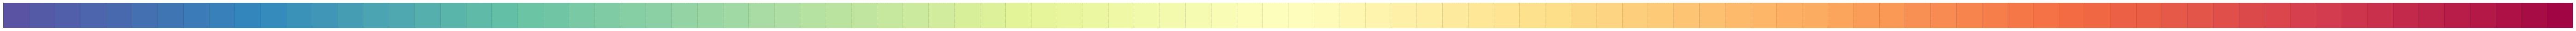

In [44]:
with plt.style.context('randy_olson_style'):
    
    colores_rgb = 
    colores_rgb = [c for c in colores_rgb]
    colores_rgb.reverse()
    sns.palplot(colores_rgb)

In [51]:
colores_rgb[69]

(0.99238754325259515, 0.69388696655132631, 0.3900807381776239)

In [32]:
scores_tipo['SERVICIOS'].dependencia.value_counts()

CFE                     310
IMSS                     71
ISSSTE                   71
ASA                      51
CONAGUA                  44
PEMEX                    41
SCT                      40
SAT                      34
SAGARPA                  32
PROSPERA                 26
LICONSA                  24
DICONSA                  17
INIFAP                   14
CAPUFE                   14
SEMARNAT                 12
TELECOMM                 12
PGR                      11
ASERCA                   10
CINVESTAV                10
CONAFE                    9
CDI                       9
CENACE                    9
SEDESOL                   9
INEGI                     9
PGPB                      8
CONANP                    8
RAN                       7
NAFIN                     7
PPQ                       5
SSA                       5
IMP                       5
FIRA                      5
FIRCO                     4
SEDENA                    4
INSP                      3
SEGOB               

In [12]:
conceptos

['general', 'competencia', 'transparencia', 'anomalias']

In [13]:
[conceptos[i] for i in range(1, 4)]

['competencia', 'transparencia', 'anomalias']

In [5]:
# por tipo y competencia tengo las UC, le tengo que pegar a todas su dependencia y nombre de UC
# Sacar los promedios ponderados

scores.keys()

dict_keys([('ADQUISICIONES', 'competencia'), ('ADQUISICIONES', 'transparencia'), ('ADQUISICIONES', 'anomalias'), ('SERVICIOS', 'competencia'), ('SERVICIOS', 'transparencia'), ('SERVICIOS', 'anomalias'), ('OBRA PUBLICA', 'competencia'), ('OBRA PUBLICA', 'transparencia'), ('OBRA PUBLICA', 'anomalias'), ('ARRENDAMIENTOS', 'competencia'), ('ARRENDAMIENTOS', 'transparencia'), ('ARRENDAMIENTOS', 'anomalias'), ('SERVICIOS RELACIONADOS CON LA OP', 'competencia'), ('SERVICIOS RELACIONADOS CON LA OP', 'transparencia'), ('SERVICIOS RELACIONADOS CON LA OP', 'anomalias')])

In [6]:
tipo, concepto

('SERVICIOS RELACIONADOS CON LA OP', 'anomalias')

In [7]:
scores[tipo, concepto].sort_values(ascending=False)

CLAVEUC
009000999    100.000000
009000959     92.805930
018TQA001     82.898053
011MDE998     73.347171
009000963     71.254441
016B00999     69.032896
016B00006     68.129090
008I00001     66.810930
016B00016     66.189253
019GYR073     65.110559
009000062     64.702818
011L6W986     64.492282
019GYN089     64.492282
007HXA999     64.492282
019GYN023     64.492282
016B00060     64.481689
009000988     63.987692
009KDH999     63.980657
009000997     63.602716
016B00997     62.870537
009JZL001     62.430548
018TOQ051     61.803974
009000950     61.330888
009000998     61.172827
047AYB003     61.097952
018TOQ080     60.980906
006E00035     60.048276
019GYN009     59.885691
047AYB011     59.501808
006AYB003     58.412031
019GYN025     58.043054
009000970     57.925141
006AYB019     57.774336
009000957     57.696365
006AYB017     57.163614
016B00985     56.888789
006E00032     56.439780
019GYR119     55.812905
027000002     55.734356
009J0U004     55.699778
011MGC998     55.251923
016B0098

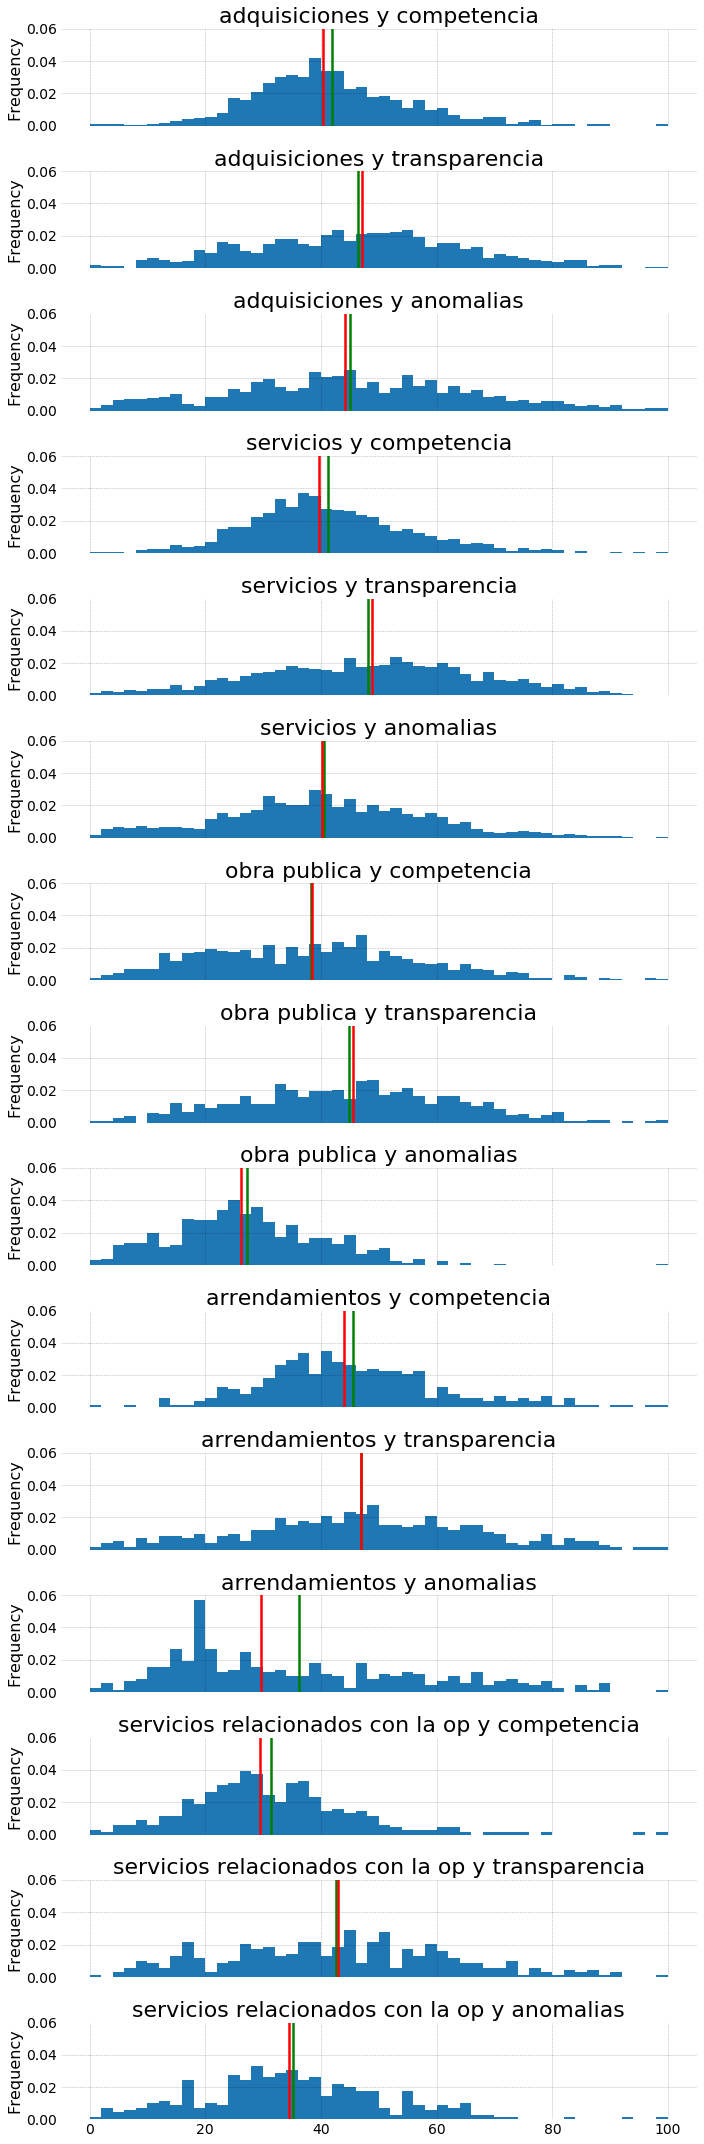

In [6]:

with plt.style.context('randy_olson_style'):
    fig, axs = plt.subplots(ncols=1, nrows=len(scores), sharex=True, sharey=True, figsize=(10, 30))
    for ax, (tipo, concepto) in zip(axs.flatten(), scores):
        df_aux = scores[tipo, concepto]    
        median, avg = df_aux.median(), df_aux.mean()
        df_aux.plot.hist(
            50, ax=ax, title=f'{tipo.lower()} y {concepto}', normed=True
        )
        # ax.annotate(f'{mediana: 2.2f}', xy=(mediana + 1, 0.2))
        ax.axvline(x=avg, color='green')
        ax.axvline(x=median, color='red')
    plt.tight_layout()

In [ ]:
## Asignar nombre

In [7]:
df_procedimientos = feather.read_dataframe(
    '../data/bases/procedimientos_all_2017_10_29.feather',
    columns=['CLAVEUC', 'DEPENDENCIA', 'NOMBRE_DE_LA_UC', 'SIGLAS'], nthreads=7,
)
# dependencias
df_nombres_dep = df_procedimientos.loc[:, ['CLAVEUC', 'SIGLAS']].drop_duplicates()
nombres_dep = {row.CLAVEUC: row.SIGLAS for row in df_nombres_dep.itertuples()}

#unidades
df_nombres_uc = df_procedimientos.loc[:, ['CLAVEUC', 'NOMBRE_DE_LA_UC']].drop_duplicates()
nombres_uc = {row.CLAVEUC: row.NOMBRE_DE_LA_UC for row in df_nombres_uc.itertuples()}
del df_procedimientos, df_nombres_dep, df_nombres_uc

scores_tipo = {}
for tipo in tipos_contratacion:
    df_aux = pd.concat(
        [scores[tipo, concepto] for concepto in conceptos if concepto != 'general'],
        axis=1, join='outer'
    )
    df_aux = df_aux.rename(columns={i: conceptos[i + 1] for i in range(0, 3)})
    # Asignar dependencia y uc
    df_aux = df_aux.reset_index()
    df_aux = df_aux.assign(dependencia=df_aux.CLAVEUC.map(nombres_dep))
    df_aux = df_aux.assign(nombre_uc=df_aux.CLAVEUC.map(nombres_uc))
    df_aux = df_aux.set_index('CLAVEUC')
    # guardar
    scores_tipo[tipo] = df_aux
{k: v.shape[0] for k, v in scores_tipo.items()}

{'ADQUISICIONES': 1150,
 'ARRENDAMIENTOS': 360,
 'OBRA PUBLICA': 665,
 'SERVICIOS': 1223,
 'SERVICIOS RELACIONADOS CON LA OP': 346}

In [8]:
## Asignar monto y procedimientos

In [9]:
scores_tipo_info = {}
for tipo in tipos_contratacion:
    df_info = pd.read_csv(f'../data/conceptos/general/{tipo}/features.csv', dtype={'CLAVEUC': str})
    df_info = df_info.set_index('CLAVEUC')
    scores_tipo_info[tipo] = pd.concat([scores_tipo[tipo], df_info], join='inner', axis=1).reset_index()
    # scores_tipo_info[tipo].to_csv(f'../data/jose_luis/ucs/{tipo}.csv', index=False, encoding='utf-8', quoting=1)


In [10]:
scores_tipo_info_dep = {}
for tipo in tipos_contratacion:
    df_aux = scores_tipo_info[tipo].copy()
    df_aux = df_aux.groupby('dependencia').agg(
        {'competencia': 'mean', 'transparencia': 'mean', 'anomalias': 'mean',
         'CLAVEUC': 'count', 'monto_total': 'sum', 'conteo_procedimientos': 'sum'}
    )
    df_aux = df_aux.reset_index()
    df_aux = df_aux.rename(columns={'CLAVEUC': 'numero_UCs'})
    df_aux.to_csv(f'../data/jose_luis/deps/{tipo}.csv')
    scores_tipo_info_dep[tipo] = df_aux


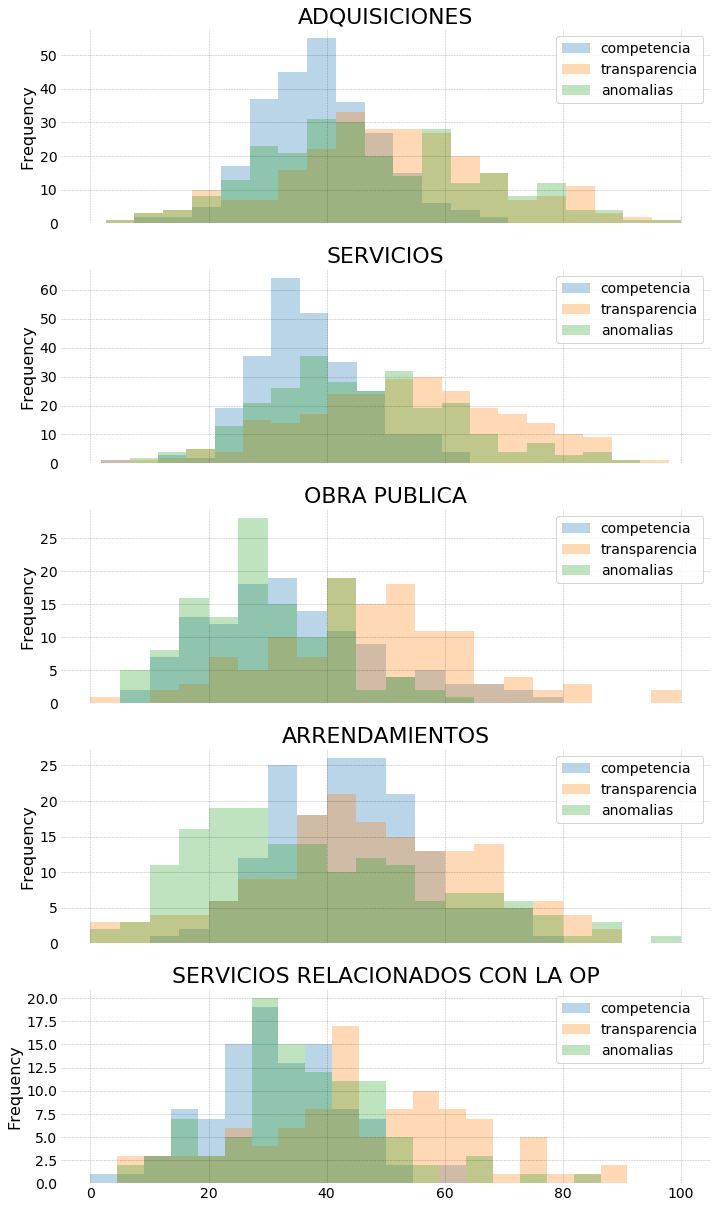

In [11]:

with plt.style.context('randy_olson_style'):
    fig, axs = plt.subplots(ncols=1, nrows=len(tipos_contratacion), figsize=(10, 17), sharex=True)
    for tipo, ax in zip(tipos_contratacion, axs.flatten()):
        df_aux = scores_tipo_info_dep[tipo][['competencia', 'transparencia', 'anomalias']]
        df_aux.plot.hist(bins=20, ax=ax, alpha=0.3, title=tipo, stacked=False)
    plt.tight_layout()

In [ ]:
# tipos_contratacion = (
#     'SERVICIOS',
#     'ARRENDAMIENTOS',
#     'ADQUISICIONES',
#     'OBRA PUBLICA',
#     'SERVICIOS RELACIONADOS CON LA OP'
# )


# scores_ponderados = {}    
# for tipo in tipos_contratacion:
#     print(tipo)
#     df_test = scores_tipo[tipo].reset_index().copy()
#     df_test = pd.merge(df_test, get_pc_procs(df_test),
#                        on='CLAVEUC', how='inner')
#     df_test = pd.merge(df_test, get_pc_monto(df_test),
#                        on='CLAVEUC', how='inner')
#     df_test = df_test.assign(
#         # competencia
#         competencia_dep_procs=df_test.competencia * df_test.pc_procs_en_dep,
#         competencia_dep_monto=df_test.competencia * df_test.pc_monto_en_dep,
#         # transparencia
#         transparencia_dep_procs=df_test.transparencia * df_test.pc_procs_en_dep,
#         transparencia_dep_monto=df_test.transparencia * df_test.pc_monto_en_dep,
#         # Anomalias
#         anomalias_dep_procs=df_test.anomalias * df_test.pc_procs_en_dep,
#         anomalias_dep_monto=df_test.anomalias * df_test.pc_monto_en_dep,
#     )
#     df_test = (df_test.groupby('dependencia', as_index=False)
#                       .agg({'competencia_dep_procs': sum,
#                             'competencia_dep_monto': sum,
#                             'transparencia_dep_procs': sum,
#                             'transparencia_dep_monto': sum,
#                             'anomalias_dep_procs': sum,
#                             'anomalias_dep_monto': sum}))
#     scores_ponderados[tipo] = df_test
    
# # df_test.head()

In [ ]:
['ISSFAM-DIRECCION DE OBRAS #007HXA999',
 'SAGARPA-DELEGACION NAYARIT #008000982',
 'ASA-ESTACION DE COMBUSTIBLES DE MORELIA MICH',
 'ASA-ESTACION DE COMBUTIBLES DE ZACATECAS',
 'ININ-DEPARTAMENTO DE ADQUISICIONES',
 'ISSSTE-HOSPITAL REGIONAL MONTERREY COORDINACION DE RECURSOS MATERIALES',
 'ISSSTE-HOSPITAL REGIONAL MORELIA COORDINACION DE REC MATERIALES #019GYN882',
 'IMSS-UMAE HOSPITAL DE ESPECIALIDADES N25 DEPTO DE ABASTECIMIENTO #019GYR059']


['ISSFAM-DIRECCION DE OBRAS #007HXA999',
 'SAGARPA-DELEGACION NAYARIT #008000982',
 'ASA-ESTACION DE COMBUSTIBLES DE MORELIA MICH',
 'ASA-ESTACION DE COMBUTIBLES DE ZACATECAS',
 'ININ-DEPARTAMENTO DE ADQUISICIONES',
 'ISSSTE-HOSPITAL REGIONAL MONTERREY COORDINACION DE RECURSOS MATERIALES',
 'ISSSTE-HOSPITAL REGIONAL MORELIA COORDINACION DE REC MATERIALES #019GYN882',
 'IMSS-UMAE HOSPITAL DE ESPECIALIDADES N25 DEPTO DE ABASTECIMIENTO #019GYR059']